In [2]:
import torch
import torch.nn as nn
# import torch.optim as optim
# import torch.nn.init as init

# 추가적인 모듈
import torchvision
from torch.utils import data # Data의 batch size 설정 및 random하게 섞기 등을 해주는 모듈
import torchsummary

import utils

In [3]:
batch_size = 32*8
learning_rate = 0.001
num_epoch = 30

transform = torchvision.transforms.Compose(
    torchvision.transforms.ToTensor(),  # convert image to Tensor
)

In [4]:
train_data=torchvision.datasets.MNIST("../DataSets/", train=True, transform=torchvision.transforms.ToTensor(), target_transform=None, download=True)
test_data=torchvision.datasets.MNIST("../DataSets/", train=False, transform=torchvision.transforms.ToTensor(), target_transform=None, download=True)

dataset_size = len(train_data)
train_size = int(dataset_size * 0.8)
test_size = int(32)
validation_size = dataset_size - train_size - test_size

train_dataset, val_dataset, train_test = data.random_split(train_data, [train_size, validation_size, test_size])

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, drop_last=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6, drop_last=True)
test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=6, drop_last=True)
train_test_loader = data.DataLoader(train_test, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [5]:
print(train_data)
print(train_data[0][0].shape)
print(train_loader)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../DataSets/
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([1, 28, 28])


In [6]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()

        # 점선 화살표 부분 맞춰는 코드
        # stride가 1이 아니거나(outplane이 /2로 작아지거나) or in_channel이 out_channel*expansion()
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [7]:
class ResCRNN(nn.Module):
    def __init__(self, num_block: int = [3, 3], num_classes: int = 10, init_weights: bool = True) -> None:
        super().__init__()

        self.in_channels = 64
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.conv2_x = self._make_layer(BottleNeck, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(BottleNeck, 128, num_block[1], 2)
        self.c01 = nn.Sequential(
            nn.Conv2d(128 * BottleNeck.expansion, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU()
        ) #[batch,1,7,7]

        self.rnn = nn.RNN(input_size=7, hidden_size=20, num_layers=1, batch_first=True)

        self.fc = nn.Linear(140, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inplanes, out_channels, stride))
            self.inplanes = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x, hidden=torch.zeros(1, 2, 20, requires_grad=True).to(torch.device('cuda'))):#
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.c01(output) 
        # print(output.shape) # shape = [batch,1,7,7]
        output = output.view([output.shape[0], 7, 7])
        print(output.shape)
        outputs, hidden = self.rnn(output, hidden)
        # output = torch.cat((output11, output21, output31, output41), dim=1)       
        print(hidden.shape)
        # print(outputs.shape)
        # output = self.final_conv(output)

        outputs = torch.flatten(outputs, 1)
        # print(outputs.shape)
        outputs = self.fc(outputs)
        return outputs

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResCRNN([3, 3]).to(device)

# 모델이 잘 통과하는지 확인
x = torch.randn(32, 1, 28, 28).to(device)
hidden = torch.zeros(1, 32, 20, requires_grad=True).to(device)
output = model(x, hidden)
print(output.size())

# 모델 summary
torchsummary.summary(model, (1, 28, 28), device=device.type)
# torchsummary.summary(model, (1, 28, 28), hidden, device=device.type)

torch.Size([32, 7, 7])
torch.Size([1, 32, 20])
torch.Size([32, 10])
torch.Size([2, 7, 7])
torch.Size([1, 2, 20])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             576
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]           4,096
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          36,864
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
           Conv2d-11          [-1, 256, 14, 14]          16,384
      BatchNorm2d-12          [-1, 256, 14, 14]       

In [8]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResCRNN([3,3]).to(device)

loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                epochs=num_epoch,
                                                max_lr=0.01,
                                                pct_start=0.3,
                                                steps_per_epoch=1
                                                )
loss_array = []
accuracy_array = []

test_model_flag = False

In [9]:
train_datas = train_test_loader if test_model_flag is True else train_loader
lrs = []
val_rnn_acc = 0
for i in range(num_epoch):
    print("epoch", i, "is start")
    for j, [img, label] in enumerate(train_datas):
        x = img.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        hidden = torch.zeros(1, batch_size, 20, requires_grad=True).to(device)
        output= model.forward(x, hidden=hidden)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if ((j == 0) if test_model_flag is True else (j % 100 == 0)):
            loss_array.append(loss.detach().cpu().numpy())
            val_rnn_acc = utils.cal_rnn_acc(model=model,
                                    datas=train_test_loader if test_model_flag is True else test_loader,
                                    device=device,
                                    hidden = torch.zeros(1, batch_size, 20, requires_grad=True).to(device))
            print('Accuracy of Test Data: {0:.3f}, loss: {1:.4f},  lr: {2:.6f}'.format(val_rnn_acc, loss_array[-1], optimizer.param_groups[0]['lr']))
            accuracy_array.append(val_rnn_acc.detach().cpu().numpy())
            if val_rnn_acc > 99.5:
                break
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    if val_rnn_acc > 99.5:
                break

epoch 0 is start
Accuracy of Test Data: 7.762, loss: 2.3047,  lr: 0.0040
Accuracy of Test Data: 71.985, loss: 1.0284,  lr: 0.0040
epoch 1 is start
Accuracy of Test Data: 93.830, loss: 0.2375,  lr: 0.0077
Accuracy of Test Data: 97.226, loss: 0.1114,  lr: 0.0077
epoch 2 is start
Accuracy of Test Data: 97.756, loss: 0.0645,  lr: 0.0181
Accuracy of Test Data: 98.067, loss: 0.0257,  lr: 0.0181
epoch 3 is start
Accuracy of Test Data: 98.367, loss: 0.0197,  lr: 0.0336
Accuracy of Test Data: 98.448, loss: 0.0252,  lr: 0.0336
epoch 4 is start
Accuracy of Test Data: 98.417, loss: 0.0263,  lr: 0.0520
Accuracy of Test Data: 98.638, loss: 0.0207,  lr: 0.0520
epoch 5 is start
Accuracy of Test Data: 98.658, loss: 0.0058,  lr: 0.0704
Accuracy of Test Data: 98.838, loss: 0.0154,  lr: 0.0704
epoch 6 is start
Accuracy of Test Data: 98.698, loss: 0.0140,  lr: 0.0859
Accuracy of Test Data: 98.928, loss: 0.0153,  lr: 0.0859
epoch 7 is start
Accuracy of Test Data: 98.868, loss: 0.0165,  lr: 0.0963
Accuracy o

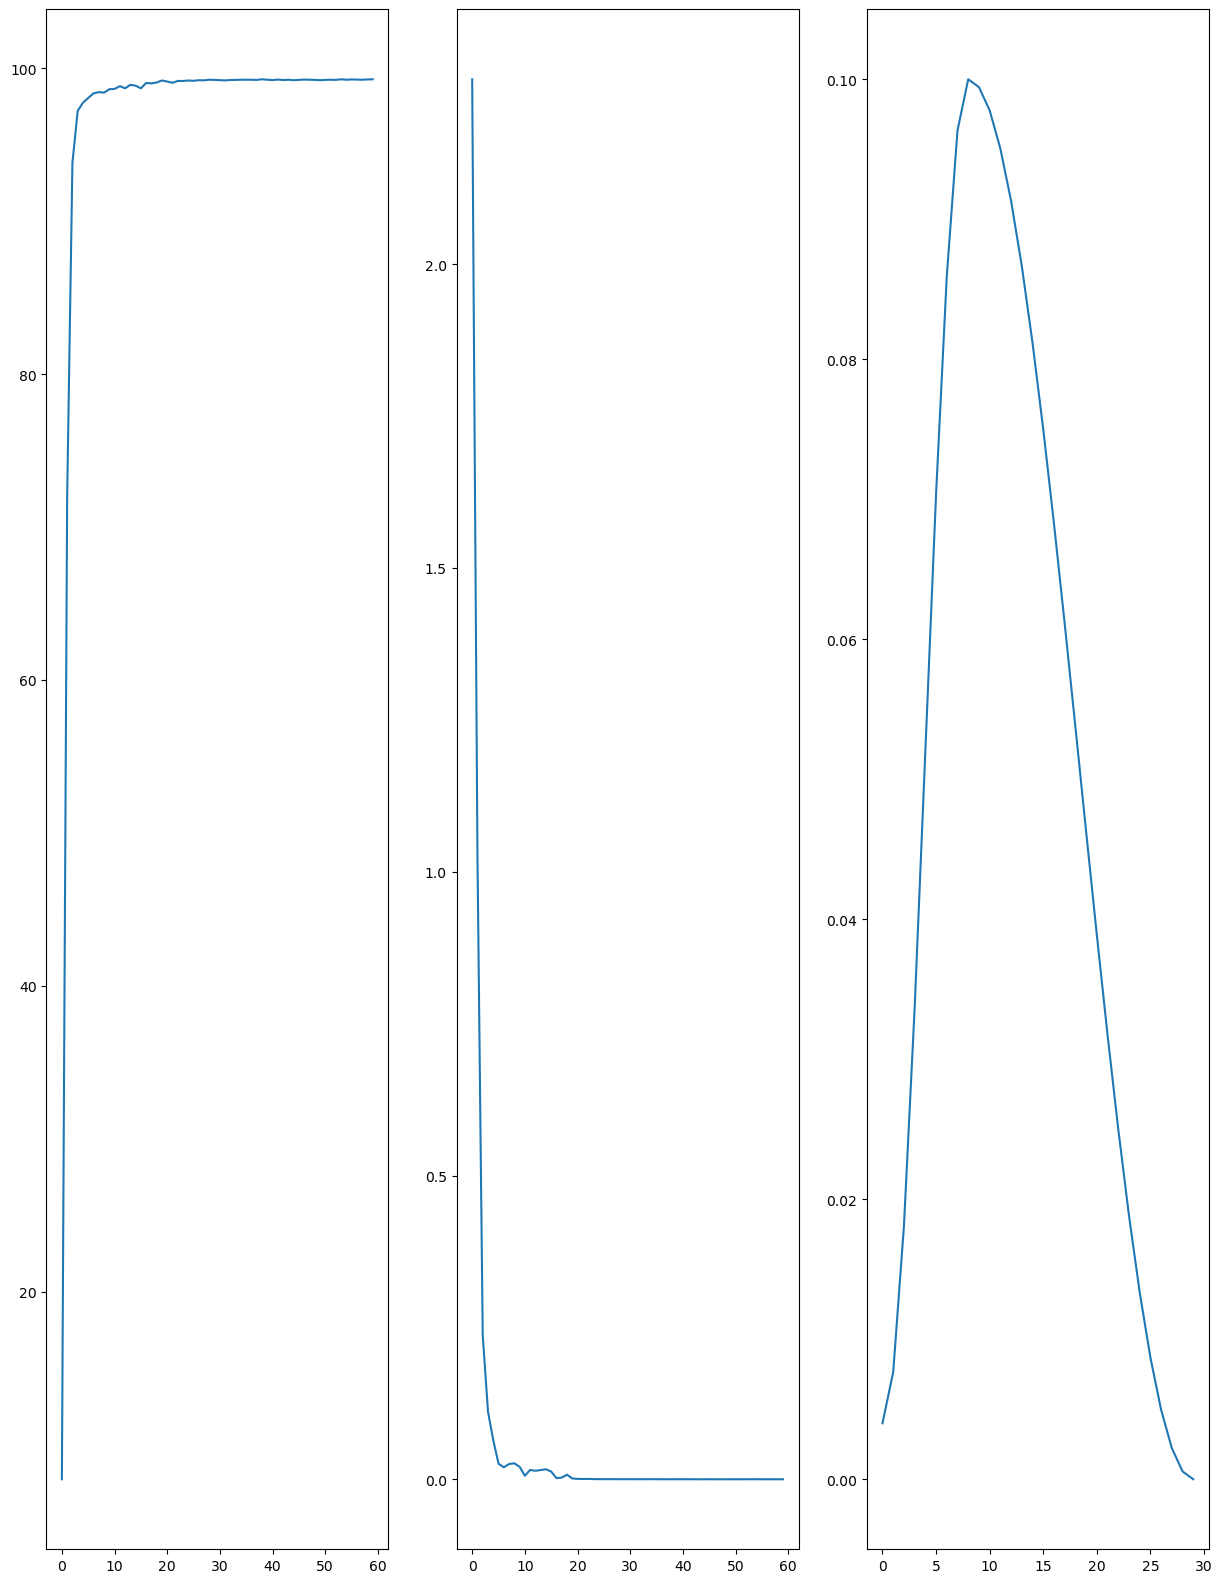

In [14]:
import utils
utils.plot_acc_loss(accuracy_array=accuracy_array, loss_array=loss_array, lrs=lrs)

In [23]:
testdata_acc = utils.cal_rnn_acc(model=model,
                                    datas= test_loader,
                                    device=device,
                                    hidden = torch.zeros(1, batch_size, 20, requires_grad=True).to(device))
print("Accuracy of Test Data: {}".format(testdata_acc))

Accuracy of Test Data: 99.26882934570312
